In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

from clearml import Task

DATA_PATH = os.path.join("..", "data", "raw", "IMDB Dataset.csv")
MODEL_DIR = os.path.join("..", "models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("DATA_PATH:", DATA_PATH)
print("MODEL_DIR:", MODEL_DIR)

/Users/vohmin.ae/Desktop/mlops_movie_sentiment/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


DATA_PATH: ../data/raw/IMDB Dataset.csv
MODEL_DIR: ../models


In [3]:
task = Task.init(
    project_name="MLOps IMDB Sentiment",
    task_name="linear_svc_tfidf_v1",
    task_type=Task.TaskTypes.training,
)

ClearML Task: created new task id=6777a431261e4c1a9e9ece7210d2619d
2025-12-11 14:32:21,124 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/1df5f41282ec4f7a8bbf2b6c322e0a53/experiments/6777a431261e4c1a9e9ece7210d2619d/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Monitor: Reporting detected, reverting back to iteration based reporting


In [4]:
logger = task.get_logger()

In [7]:
config = {
    "random_state": 42,
    "test_size": 0.2,
    "vectorizer": {
        "max_features": 10000,
        "ngram_range": [1, 2],
        "stop_words": "english",
    },  
    "model": {
        "type": "LogisticRegression",
        "max_iter": 1000,
        "n_jobs": -1,
    },
    "data": {
        "path": DATA_PATH,
        "source": "Kaggle: IMDB Dataset of 50k Movie Reviews",
    },
    "preprocessing_version": "linear_svc_tfidf_v1"
}

task.connect(config)

config

{'random_state': 42,
 'test_size': 0.2,
 'vectorizer': {'max_features': 10000,
  'ngram_range': [1, 2],
  'stop_words': 'english'},
 'model': {'type': 'LogisticRegression', 'max_iter': 1000, 'n_jobs': -1},
 'data': {'path': '../data/raw/IMDB Dataset.csv',
  'source': 'Kaggle: IMDB Dataset of 50k Movie Reviews'},
 'preprocessing_version': 'linear_svc_tfidf_v1'}

In [5]:
df = pd.read_csv(DATA_PATH)

print("Форма датасета:", df.shape)
df.head()

Форма датасета: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64


/Users/vohmin.ae/Desktop/mlops_movie_sentiment/.venv/lib/python3.9/site-packages/clearml/utilities/plotlympl/renderer.py:209: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



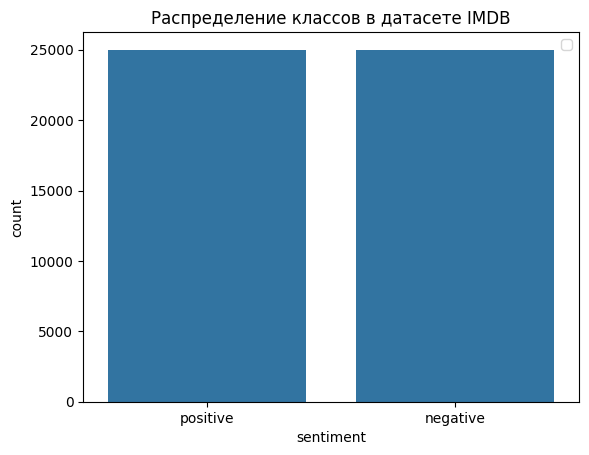

In [ ]:
print(df["sentiment"].value_counts(normalize=True))

sns.countplot(data=df, x="sentiment")
plt.title("Распределение классов в датасете IMDB")
plt.show()

In [8]:
X = df["review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=config["test_size"],
    random_state=config["random_state"],
    stratify=y
)

print("Размер train:", X_train.shape[0])
print("Размер test:", X_test.shape[0])

Размер train: 40000
Размер test: 10000


In [9]:
vectorizer = TfidfVectorizer(
    max_features=config["vectorizer"]["max_features"],
    ngram_range=tuple(config["vectorizer"]["ngram_range"]),
    stop_words=config["vectorizer"]["stop_words"],
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Форма X_train_vec:", X_train_vec.shape)
print("Форма X_test_vec:", X_test_vec.shape)

Форма X_train_vec: (40000, 10000)
Форма X_test_vec: (10000, 10000)


In [ ]:
logreg = LogisticRegression(
    max_iter=config["model"]["max_iter"],
    n_jobs=config["model"]["n_jobs"],
)

logreg.fit(X_train_vec, y_train)

y_pred = logreg.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (Logistic Regression): {acc:.4f}")

report_text = classification_report(y_test, y_pred)
print("\nClassification report:")
print(report_text)

logger.report_scalar(
    title="accuracy",
    series="logreg_tfidf",
    value=acc,
    iteration=0,
)

logger.report_text(
    "classification_report",
    "logreg_tfidf",
    report_text,
    iteration=0,
)

cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])
cm_df = pd.DataFrame(
    cm,
    index=["neg_true", "pos_true"],
    columns=["neg_pred", "pos_pred"],
)

sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

logger.report_confusion_matrix(
    title="confusion_matrix",
    series="logreg_tfidf",
    matrix=cm,
    xaxis=["negative", "positive"],
    yaxis=["negative", "positive"],
    iteration=0,
)

Accuracy (Logistic Regression): 0.8968

Classification report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

2025-12-09 18:59:01,806 - clearml.Task - ERROR - Logger failed casting log level "logreg_tfidf" to integer
classification_report


LinearSVC accuracy: 0.8913
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



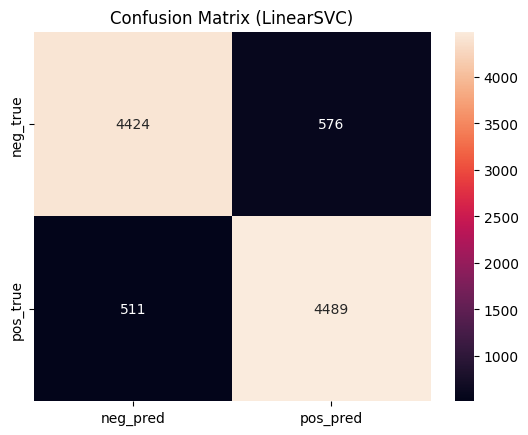

2025-12-11 14:37:26,311 - clearml.Task - ERROR - Logger failed casting log level "linear_svc_tfidf_v1" to integer
classification_report


In [13]:
svc = LinearSVC(random_state=42)
svc.fit(X_train_vec, y_train)

y_pred_svc = svc.predict(X_test_vec)

acc_svc = accuracy_score(y_test, y_pred_svc)
print("LinearSVC accuracy:", acc_svc)

report_text_svc = classification_report(y_test, y_pred_svc)
print(report_text_svc)

labels = ["negative", "positive"]
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=labels)
cm_svc_df = pd.DataFrame(
    cm_svc,
    index=["neg_true", "pos_true"],
    columns=["neg_pred", "pos_pred"],
)
sns.heatmap(cm_svc_df, annot=True, fmt="d")
plt.title("Confusion Matrix (LinearSVC)")
plt.show()

logger.report_scalar(
    title="accuracy",
    series="linear_svc_tfidf_v1",
    value=acc_svc,
    iteration=0,
)

logger.report_text(
    "classification_report",
    "linear_svc_tfidf_v1",
    report_text_svc,
    iteration=0,
)

logger.report_confusion_matrix(
    title="Confusion Matrix - LinearSVC TF-IDF v1",
    series="linear_svc_tfidf_v1",
    matrix=cm_svc,
    iteration=0,
    xlabels=labels,
    ylabels=labels,
)

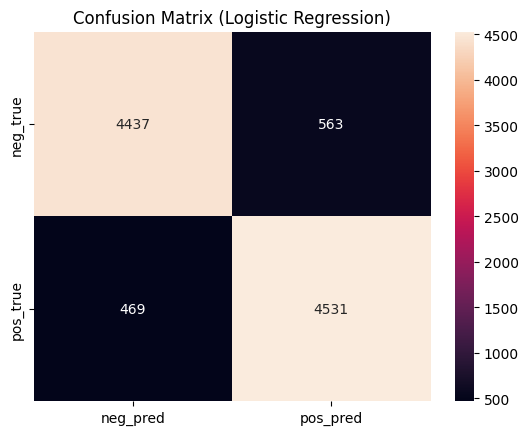

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])
cm_df = pd.DataFrame(
    cm,
    index=["neg_true", "pos_true"],
    columns=["neg_pred", "pos_pred"],
)

sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

logger.report_confusion_matrix(
    title="confusion_matrix",
    series="logreg_tfidf",
    matrix=cm,
    xaxis=["negative", "positive"],
    yaxis=["negative", "positive"],
    iteration=0,
)

In [ ]:
model_path = os.path.join(MODEL_DIR, "logreg_imdb.joblib")
vec_path = os.path.join(MODEL_DIR, "tfidf_imdb.joblib")

joblib.dump(logreg, model_path)
joblib.dump(vectorizer, vec_path)

print("Модель сохранена в:", model_path)
print("Векторизатор сохранён в:", vec_path)

task.upload_artifact(
    name="logreg_model_v1",
    artifact_object=model_path,
)

task.upload_artifact(
    name="tfidf_vectorizer_v1",
    artifact_object=vec_path,
)

Модель сохранена в: ../models/logreg_imdb.joblib
Векторизатор сохранён в: ../models/tfidf_imdb.joblib


True

In [14]:
task.close()